In [6]:
from src.utils.audio import record_with_arecord, stt_pipeline
from src.utils.file_io import read_text_file, write_text_file, write_output
from src.utils.config import INPUT_TXT_PATH, OUTPUT_TXT_PATH
from src.nodes.classify import classify_input

from typing import TypedDict, Annotated, List, Dict, Any # Imports all the data types we need
from langgraph.graph import StateGraph, START, END
import time

In [7]:
class AgentState(TypedDict):
    input_text: str                     # 最新轉錄文字
    classification: Dict[str, Any]      # classify_input 結果
    commands: List[Dict[str, Any]]      # 多動作時的指令列表
    status: str                         # "start", "classified", "short_executed", "llm_needed", "success", "error"

def record(state: AgentState) -> AgentState:
    """樹莓派的錄音節點"""
    wav_path = record_with_arecord(duration=6, device="plughw:3,0")
    if not wav_path:
        print("record node error")
    state["status"] = "record"
    return state

def analyze(state: AgentState) -> AgentState:
    """whisper.cpp解析.wav檔案並寫入input.txt"""
    text = stt_pipeline(duration=6, device="plughw:3,0")
    return {"input_text": text, "status": "analyzed" if text else "analyze_error"}

def read_input(state: AgentState) -> AgentState:
    """讀取input.txt的內容"""
    input_text = read_text_file(INPUT_TXT_PATH)
    return {"input_text": input_text}

def classify_decision(state: AgentState) -> AgentState:
    """命令的類型是明確或模糊"""
    classification = classify_input(state["input_text"])
    return {"classification": classification, "status": classification["type"]}

def route_after_classify(state: AgentState) -> str:
    """路由函式（只回傳字串鍵）"""
    if state["classification"]["type"] == "short":
        return "explicit"
    else:
        return "implicit"

def direct_action(state: AgentState) -> AgentState: #未完成
    """直接觸發動作"""
    return state

def llm_reasoning(state: AgentState) -> AgentState: #未完成
    """LLM推理"""
    return state

In [8]:
graph = StateGraph(AgentState)

graph.add_node("record", record)
graph.add_node("analyze", analyze)
graph.add_node("read_input", read_input)
graph.add_node("classify_decision", classify_decision)
graph.add_node("direct_action", direct_action)
graph.add_node("llm_reasoning", llm_reasoning)

graph.set_entry_point("record")

graph.add_edge("record", "analyze")
graph.add_edge("analyze", "read_input")
graph.add_edge("read_input", "classify_decision")

graph.add_conditional_edges(
    "classify_decision",
    route_after_classify,
    {
        # Edge : Node
        "explicit": "direct_action",
        "implicit": "llm_reasoning"
    }
)

graph.add_edge("direct_action", END)
graph.add_edge("llm_reasoning", END)

app = graph.compile()

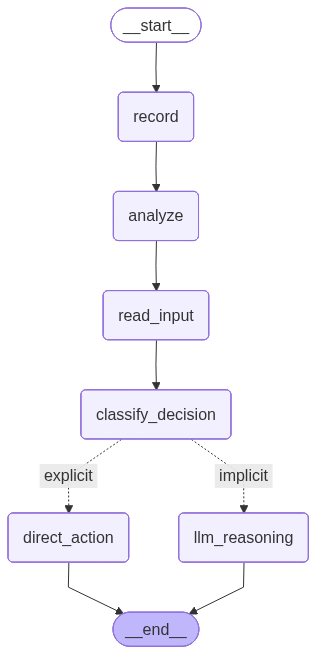

In [9]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))